# Exemplo 1: Perfil de Investidores (Anacor Simples / CA)

In [132]:
import pandas as pd
import prince
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## 1.1. Base de dados

In [22]:
# Importando os dados

df = pd.read_excel("datasets/perfil_investidor_aplicacao.xlsx")

In [23]:
#%% Visualizando os dados e cada uma das variáveis

df.head(5)


,Estudante,Perfil,Tipo de Aplicação
0,Gabriela,Conservador,Poupança
1,Luiz Felipe,Conservador,Poupança
2,Patrícia,Conservador,Poupança
3,Gustavo,Conservador,Poupança
4,Letícia,Conservador,Poupança


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Estudante          100 non-null    object
 1   Perfil             100 non-null    object
 2   Tipo de Aplicação  100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [25]:
# Estatísticas descritivas
summary = df.describe(include = 'all')
summary


,Estudante,Perfil,Tipo de Aplicação
count,100,100,100
unique,100,3,3
top,Gabriela,Agressivo,Ações
freq,1,58,45


## 1.2. Anacor Simples

### - Análises Preliminares

In [26]:
# Tabelas de frequência das variáveis
tabela_contingencia = pd.crosstab(index=df['Perfil'], columns=df['Tipo de Aplicação'])
tabela_contingencia

Tipo de Aplicação,Ações,CDB,Poupança
Perfil,,,
Agressivo,36,20,2
Conservador,5,4,8
Moderado,4,16,5


In [27]:
# Definição da quantidade de observações na tabela de contingência
n = tabela_contingencia.sum().sum()
n

100

In [28]:
#%% Analisando a significância estatística da associação (teste qui²)
# Se o p valor é menor que 0.05 então se rejeita  hipótese nula, isto é, que as variáveis não 
# tem associação estatisticamente relevantes.

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf}") # graus de liberdade

estatística qui²: 31.764164976335362
p-valor da estatística: 2.137594051381398e-06
graus de liberdade: 4


### - Processo manual

O processo descrito abaixo dá um valores diferentes daqueles dados pelo Prince, apesar de serem qualitativamente iguais.

In [42]:
# Tabela de frequências esperadas
freq_esp = pd.DataFrame(freq_esp, 
                        index = tabela_contingencia.index.values, 
                        columns = tabela_contingencia.columns.values)
freq_esp

,Ações,CDB,Poupança
Agressivo,26.10,23.2,8.70
Conservador,7.65,6.8,2.55
Moderado,11.25,10.0,3.75


In [44]:
#%%
# Resíduos – diferenças entre frequências absolutas observadas e esperadas
residues = tabela_contingencia  -freq_esp
residues

Tipo de Aplicação,Ações,CDB,Poupança
Perfil,,,
Agressivo,9.90,-3.2,-6.70
Conservador,-2.65,-2.8,5.45
Moderado,-7.25,6.0,1.25


In [45]:
# Valores de qui-quadrado por célula
chi2_table = (tabela_contingencia  -freq_esp)**2/freq_esp
chi2_table

Tipo de Aplicação,Ações,CDB,Poupança
Perfil,,,
Agressivo,3.755172,0.441379,5.159770
Conservador,0.917974,1.152941,11.648039
Moderado,4.672222,3.600000,0.416667


In [48]:
# Resíduos padronizados
std_residuals = (tabela_contingencia - freq_esp) / np.sqrt(freq_esp)
std_residuals

Tipo de Aplicação,Ações,CDB,Poupança
Perfil,,,
Agressivo,1.937827,-0.664364,-2.271513
Conservador,-0.958110,-1.073751,3.412922
Moderado,-2.161532,1.897367,0.645497


In [50]:
# Resíduos padronizados ajustados
from scipy.stats.contingency import margins

rsum, csum = margins(tabela_contingencia)
rsum = rsum.astype(np.float64)
csum = csum.astype(np.float64)
v = csum * rsum * (n - rsum) * (n - csum) / n**3
adjusted_residuals = (tabela_contingencia - freq_esp) / np.sqrt(v)


adjusted_residuals

Tipo de Aplicação,Ações,CDB,Poupança
Perfil,,,
Agressivo,4.031893,-1.323444,-3.801728
Conservador,-1.418061,-1.521559,4.063291
Moderado,-3.365501,2.828427,0.808452


[Text(0.5, 0, 'Ações'), Text(1.5, 0, 'CDB'), Text(2.5, 0, 'Poupança')]

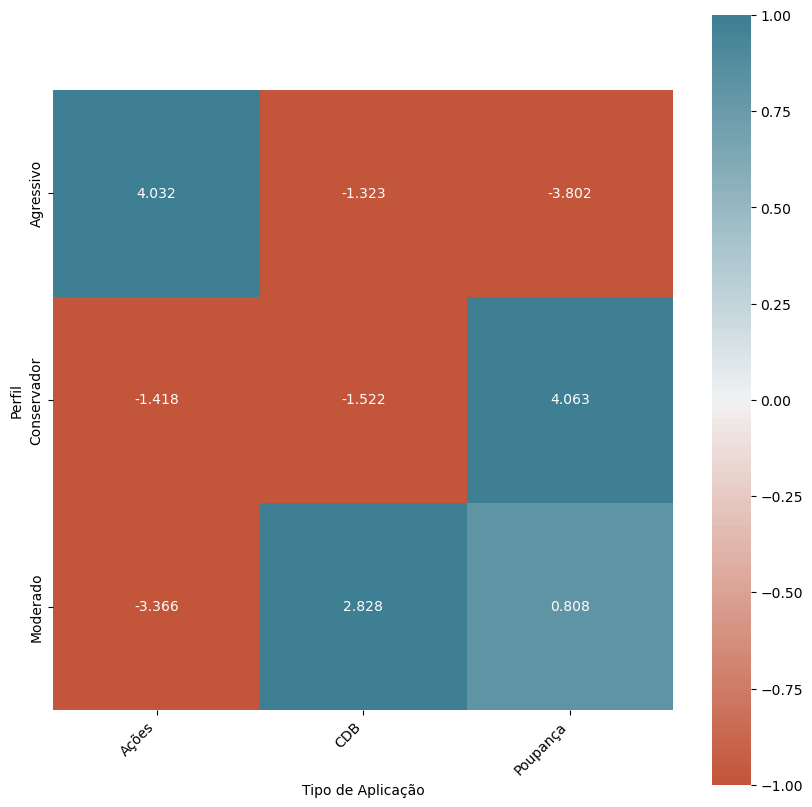

In [55]:
#%%
# Mapa de calor dos resíduos padronizados ajustados  
# Não é tão necessaŕio assim, o mais interessante aqui é conseguir ajustar o midpoint do colormap pra conseguir vizualisar os valores maiores que 1.96, em que há associação significativa entre as categorias que interagem na célula.
# A referência de 1.96 é o valor crítico da normal padrão para o nível de significância de 5%
fig = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(
    adjusted_residuals, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    fmt='.3f')

ax.set_xticklabels(
    ax.get_xticklabels(),   
    rotation=45,
    horizontalalignment='right'
)

In [56]:
# Definição da matriz A
# Resíduos padronizados (qui2$residuals) divididos pela raiz quadrada do tamanho da amostra (n)

matrizA = std_residuals/np.sqrt(n)
matrizA = matrizA.values
matrizA

array([[ 0.19378267, -0.06643638, -0.22715127],
       [-0.09581095, -0.1073751 ,  0.34129224],
       [-0.21615324,  0.18973666,  0.06454972]])

In [57]:
# Definição da matriz W
# Multiplicação da matriz A transposta pela matriz A

matrizW = np.matmul(matrizA.T, matrizA)
matrizW

array([[ 0.09345368, -0.0435987 , -0.09067015],
       [-0.0435987 ,  0.0519432 , -0.00930773],
       [-0.09067015, -0.00930773,  0.17224476]])

In [58]:

# Definição da quantidade de dimensões
nrow = len(matrizW)
ncol = len(matrizW[0])
qtde_dimensoes = min(nrow - 1, ncol - 1)
qtde_dimensoes


2

In [59]:

# Singular Value Decomposition
u, valores_singulares, vt = np.linalg.svd(matrizA)
v = vt.T
idx = valores_singulares.argsort()[::-1] # Arrumar valores singulares de maneira decrescente
valores_singulares = valores_singulares[idx]
u = u[:,idx]
v = v[:,idx] 


valores_singulares



array([4.82923258e-01, 2.90562862e-01, 9.41508110e-18])

In [60]:
# Autovalores
eigenvalues = valores_singulares**2
eigenvalues


array([2.33214873e-01, 8.44267769e-02, 8.86437520e-35])

In [62]:
# Valores singulares truncado para o número de dimensões
eigenvalues_truncated = eigenvalues[:qtde_dimensoes]
singular_truncated = valores_singulares[:qtde_dimensoes]

In [64]:
# Cálculo da inércia principal total (a partir do qui-quadrado)
# Esse valor é a soma dos autovalores
inercia_total = chi2/n
inercia_total

0.31764164976335363

In [65]:
# Cálculo da variância explicada em cada dimensão
# Esse o valor da porcentagem dos autovalores
variancia_explicada = eigenvalues_truncated / inercia_total

variancia_explicada


array([0.73420747, 0.26579253])

In [66]:
# Cálculo das massas das colunas (column profiles)
soma_colunas = np.sum(tabela_contingencia, axis = 1)
massa_colunas = soma_colunas / n

massa_colunas

Perfil
Agressivo      0.58
Conservador    0.17
Moderado       0.25
dtype: float64

In [67]:
# Cálculo das massas das linhas (row profiles)
soma_linhas  = np.sum(tabela_contingencia, axis = 0)
massa_linhas = soma_linhas / n
massa_linhas


Tipo de Aplicação
Ações       0.45
CDB         0.40
Poupança    0.15
dtype: float64

In [68]:
# Autovetores u e v das dimensões
autovetor_u = u[:,:qtde_dimensoes]
autovetor_v = v[:,:qtde_dimensoes]

autovetor_u



array([[-0.62491193, -0.17171219],
       [ 0.67162481, -0.61556487],
       [ 0.39800149,  0.76915201]])

In [69]:
autovetor_v

array([[-0.56215025, -0.48372213],
       [ 0.09300977,  0.76899232],
       [ 0.82178847, -0.41792789]])

In [70]:
# Calculando as coordenadas para plotar as categorias no mapa perceptual

# Variável em linha na tabela de contingência ('perfil')
# Coordenadas das abcissas
coord_abcissas_perfil = np.sqrt(valores_singulares[0]) * (massa_colunas**(-0.5)) * autovetor_u[:,0]
# Coordenadas das ordenadas
coord_ordenadas_perfil = np.sqrt(valores_singulares[1]) * (massa_colunas**(-0.5)) * autovetor_u[:,1]

# Variável em coluna na tabela de contingência ('aplicacao')
# Coordenadas das abcissas
coord_abcissas_aplicacao = np.sqrt(valores_singulares[0]) * (massa_linhas**(-0.5)) * autovetor_v[:,0]
# Coordenadas das ordenadas
coord_ordenadas_aplicacao = np.sqrt(valores_singulares[1]) * (massa_linhas**(-0.5)) * autovetor_v[:,1]



In [71]:
coord_perfil = pd.DataFrame({'x': coord_abcissas_perfil.values, 'y' : coord_ordenadas_perfil.values},
                            index = coord_abcissas_perfil.index.values)
coord_perfil

,x,y
Agressivo,-0.570222,-0.121537
Conservador,1.131987,-0.804766
Moderado,0.553164,0.829206


In [72]:

coord_aplicacao = pd.DataFrame({'x': coord_abcissas_aplicacao.values, 'y' : coord_ordenadas_aplicacao.values},
                            index = coord_abcissas_aplicacao.index.values)
coord_aplicacao

,x,y
Ações,-0.582352,-0.388696
CDB,0.102197,0.655408
Poupança,1.474530,-0.581669


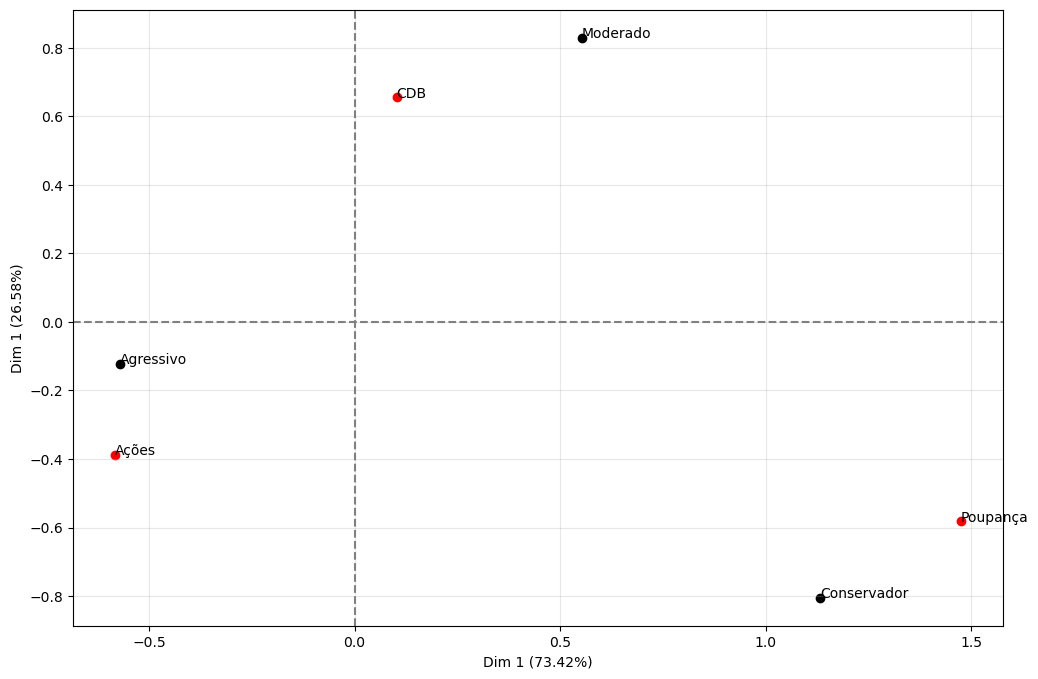

In [73]:
# Mapa perceptual

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(coord_abcissas_perfil, 
           coord_ordenadas_perfil,
           color = 'black')
ax.scatter(coord_abcissas_aplicacao, 
           coord_ordenadas_aplicacao,
           color = 'red')

ax.axhline(0, ls='--', color = 'grey')
ax.axvline(0, ls='--', color = 'grey')
ax.set_xlabel('Dim 1 ('+  str(round(variancia_explicada[0]*100,2)) +'%)')
ax.set_ylabel('Dim 1 ('+  str(round(variancia_explicada[1]*100,2)) +'%)')
ax.grid(alpha = 0.3)


for i, txt in enumerate(coord_abcissas_aplicacao.index.values):
    ax.annotate(txt, (coord_abcissas_aplicacao[i], coord_ordenadas_aplicacao[i]))
    
for i, txt in enumerate(coord_abcissas_perfil.index.values):
    ax.annotate(txt, (coord_abcissas_perfil[i], coord_ordenadas_perfil[i]))
    
plt.show()


### - Processo pelo Prince

In [29]:
#%% Elaborando a ANACOR

# Inicializando a instância da Anacor
ca = prince.CA()

In [30]:
#%% Fit do modelo

# Note que o input é a tabela de contingência criada antes

ca = ca.fit(tabela_contingencia)


In [31]:
#%% Obtendo as coordenadas em linha 
ca.row_coordinates(tabela_contingencia)

,0,1
Agressivo,-0.396262,-0.065513
Conservador,0.786648,-0.433800
Moderado,0.384408,0.446974


In [32]:
#%% Obtendo as coordenadas em coluna

ca.column_coordinates(tabela_contingencia)

,0,1
Ações,-0.404692,-0.209522
CDB,0.071019,0.353291
Poupança,1.024690,-0.313542


In [33]:
#%% Obtendo os eigenvalues

ca.eigenvalues_


[0.2332148728258384, 0.08442677693751505]

In [34]:
#%% Obtendo a inércia principal total

# É a soma dos eigenvalues (também é a divisão: estat. qui² / N)
# Quanto maior a inércia principal total, maior é a associação entre categorias

ca.total_inertia_

0.3176416497633535

In [35]:
#%% Inércia explicada por dimensão

# Indica o percentual da a inércia principal total explicado por cada dimensão

ca.explained_inertia_

[0.7342074724759363, 0.2657925275240634]

In [36]:
#%% Massas em linhas

ca.row_masses_


Agressivo      0.58
Conservador    0.17
Moderado       0.25
dtype: float64

In [37]:
#%% Massas em colunas

ca.col_masses_

Ações       0.45
CDB         0.40
Poupança    0.15
dtype: float64

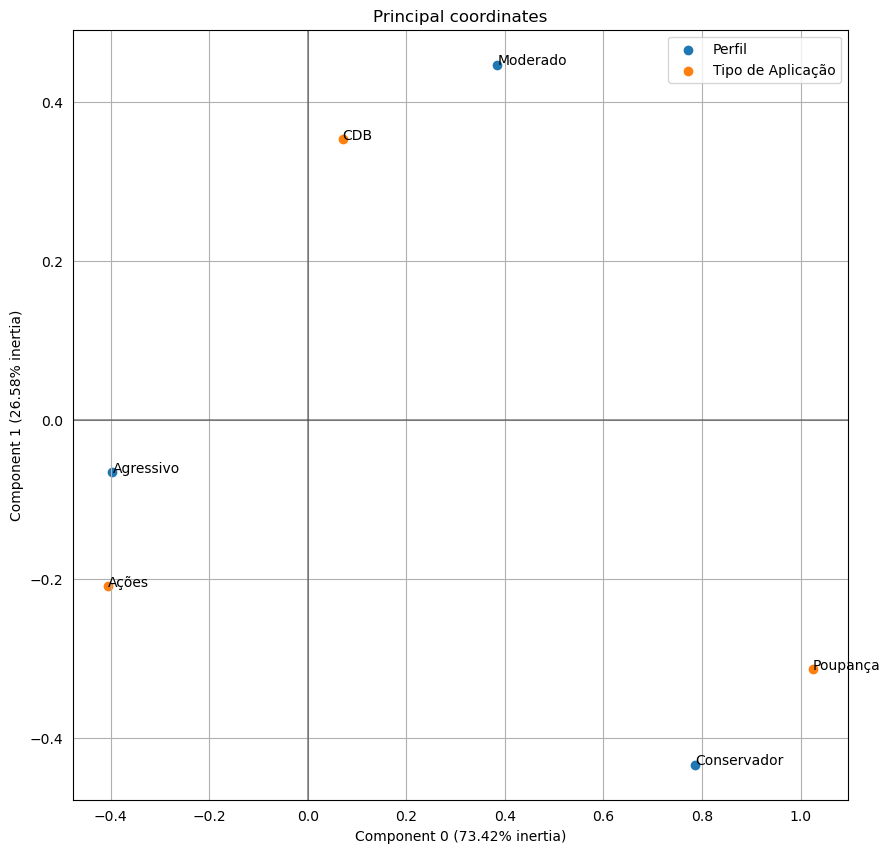

In [38]:
ax = ca.plot_coordinates(X=tabela_contingencia,
                         ax=None,
                         figsize=(10,10),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True)


In [39]:

#%% Plotando o mapa percentual interativo

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default='browser'

chart_df = pd.DataFrame({'obs_x':ca.row_coordinates(tabela_contingencia)[0].values,
                         'obs_y': ca.row_coordinates(tabela_contingencia)[1].values})

fig = go.Figure(data=go.Scatter(x=chart_df['obs_x'],
                                y=chart_df['obs_y'],
                                name=tabela_contingencia.index.name,
                                textposition="top center",
                                text=tabela_contingencia.index,
                                mode="markers+text",))

fig.add_trace(go.Scatter(
    x=ca.column_coordinates(tabela_contingencia)[0].values,
    mode="markers+text",
    name=tabela_contingencia.columns.name,
    textposition="top center",
    y=ca.column_coordinates(tabela_contingencia)[1].values,
    text=ca.column_coordinates(tabela_contingencia).index
))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title_text='Coordenadas principais'

)

fig.show()


# Exemplo 2: Perfil de Investidores (Anacor Múltipla / MCA)

## 2.1. Base de dados

In [107]:
# Importando os dados

df = pd.read_excel("datasets/perfil_investidor_aplicacao_estadocivil.xlsx")

In [108]:
#%% Visualizando os dados e cada uma das variáveis

df.head(5)


,estudante,perfil,aplicacao,estado_civil
0,Gabriela,Conservador,Poupanca,Casado
1,Luiz Felipe,Conservador,Poupanca,Casado
2,Patrícia,Conservador,Poupanca,Casado
3,Gustavo,Conservador,Poupanca,Solteiro
4,Letícia,Conservador,Poupanca,Casado


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   estudante     100 non-null    object
 1   perfil        100 non-null    object
 2   aplicacao     100 non-null    object
 3   estado_civil  100 non-null    object
dtypes: object(4)
memory usage: 3.2+ KB


In [110]:
# Estatísticas descritivas
summary = df.describe(include = 'all')
summary


,estudante,perfil,aplicacao,estado_civil
count,100,100,100,100
unique,100,3,3,2
top,Gabriela,Agressivo,Acoes,Solteiro
freq,1,58,45,57


In [111]:
#%% Separando somente as variáveis quantitativas do banco de dados

df_mca = df[["perfil", "aplicacao", "estado_civil"]]

df_mca.head(5)

,perfil,aplicacao,estado_civil
0,Conservador,Poupanca,Casado
1,Conservador,Poupanca,Casado
2,Conservador,Poupanca,Casado
3,Conservador,Poupanca,Solteiro
4,Conservador,Poupanca,Casado


## 2.2. Anacor Múltipla

### - Análises Preliminares

In [112]:
tabela_contingencia1 = pd.crosstab(index=df['perfil'], columns=df['aplicacao'])
tabela_contingencia1

aplicacao,Acoes,CDB,Poupanca
perfil,,,
Agressivo,36,20,2
Conservador,5,4,8
Moderado,4,16,5


In [113]:
tabela_contingencia2 = pd.crosstab(index=df['perfil'], columns=df['estado_civil'])
tabela_contingencia2

estado_civil,Casado,Solteiro
perfil,,
Agressivo,17,41
Conservador,12,5
Moderado,14,11


In [114]:
tabela_contingencia3 = pd.crosstab(index=df['aplicacao'], columns=df['estado_civil'])
tabela_contingencia3

estado_civil,Casado,Solteiro
aplicacao,,
Acoes,9,36
CDB,24,16
Poupanca,10,5


In [115]:
#%% Analisando a significância estatística da associação (teste qui²)
# Se o p valor é menor que 0.05 então se rejeita  hipótese nula, isto é, que as variáveis não 
# tem associação estatisticamente relevantes.

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia1)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia2)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} \n") # graus de liberdade

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia3)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf} ") # graus de liberdade

estatística qui²: 31.764164976335362
p-valor da estatística: 2.137594051381398e-06
graus de liberdade: 4 

estatística qui²: 11.437563671904417
p-valor da estatística: 0.0032837085626606414
graus de liberdade: 2 

estatística qui²: 17.856657146742826
p-valor da estatística: 0.00013257943624182006
graus de liberdade: 2 


### - Processo pelo Prince

In [116]:
#%% Elaborando a MCA 

## Utiliza o método da matriz de Burt

mca = prince.MCA()
mca = mca.fit(df_mca)

In [117]:
#%% Obtendo as coordenadas nas duas dimensões do mapa

mca.column_coordinates(df_mca)

,0,1
perfil_Agressivo,-0.653069,-0.014732
perfil_Conservador,1.129970,1.483614
perfil_Moderado,0.746741,-0.974679
aplicacao_Acoes,-0.831258,0.387515
aplicacao_CDB,0.417184,-0.935143
aplicacao_Poupanca,1.381285,1.331169
estado_civil_Casado,0.843172,-0.131145
estado_civil_Solteiro,-0.636077,0.098934


In [118]:
#%% Obtendo as coordenadas de cada um das observações

mca.row_coordinates(df_mca)




,0,1
0,1.440751,1.354770
1,1.440751,1.354770
2,1.440751,1.354770
3,0.805403,1.470920
4,1.440751,1.354770
...,...,...
95,-0.910729,0.238135
96,-0.910729,0.238135
97,-0.910729,0.238135
98,-0.910729,0.238135


In [119]:
#%% Obtendo os eigenvalues

mca.eigenvalues_



[0.6023045112620065, 0.4359878227115962]

In [120]:
#%% Inércia principal total

mca.total_inertia_



1.6666666666666667

In [121]:
#%% Obtendo a variância

mca.explained_inertia_

[0.36138270675720385, 0.2615926936269577]

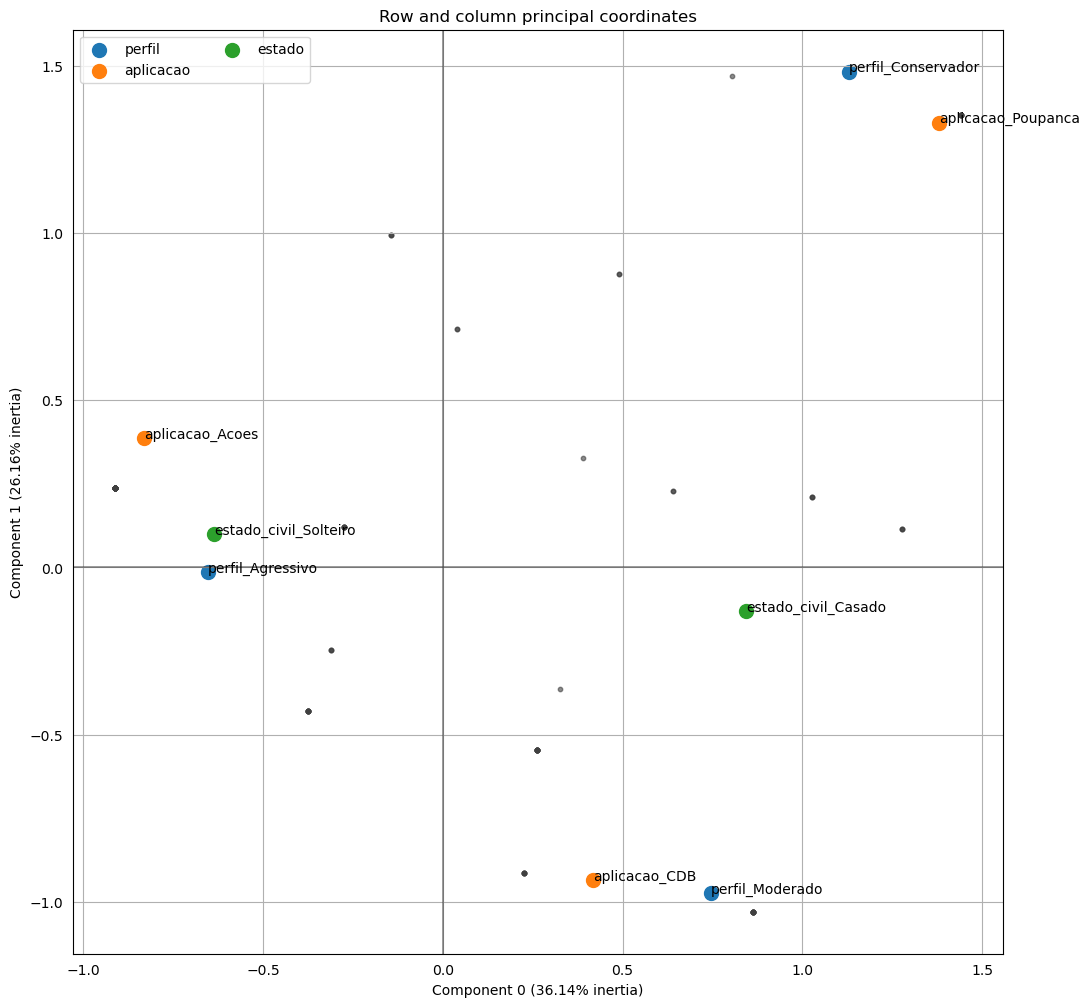

In [122]:
#%% Plotando o mapa perceptual

mp_mca = mca.plot_coordinates(
             X = df_mca,
             figsize=(12,12),
             show_row_points = True,
             show_column_points = True,
             show_row_labels=False,
             column_points_size = 100,
             show_column_labels = True,
             legend_n_cols = 2)

In [125]:
#%% Plotando o mapa perceptual interativo

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default='browser'

chart_df = pd.DataFrame({'obs_x':mca.row_coordinates(df_mca)[0],
                         'estudante': df['estudante'],
                         'obs_y': mca.row_coordinates(df_mca)[1]})

fig = go.Figure(data=go.Scatter(x=chart_df['obs_x'],
                                y=chart_df['obs_y'],
                                mode='markers',
                                name="Estudante",
                                text=chart_df['estudante']))

fig.add_trace(go.Scatter(
    x=mca.column_coordinates(df_mca)[0],
    mode='markers+text',
    name="Associação",
    marker={'size':12},
    y=mca.column_coordinates(df_mca)[1],
    textposition="top center",
    text=mca.column_coordinates(df_mca).index
))

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title_text='Coordenadas das linhas e colunas'
)

fig.show()

# Exemplo 3: Doença cardiaca (Anacor Múltipla / MCA)

## 3.1. Base de dados

In [127]:
# Importando os dados

df = pd.read_excel("datasets/dados_cor_acm.xlsx")

In [128]:
#%% Visualizando os dados e cada uma das variáveis

df.head(5)


,Idade,Sexo,Tipo_Dor_Peito,PS_Descanso,Colesterol,Açucar_Sangue,ECG_Descanso,BC_Max,Angina_Exerc,Doença_Card
0,40,Masculino,Atipica,140,289,Normal,Normal,172,Nao,Nao
1,49,Feminino,Sem_Dor,160,180,Normal,Normal,156,Nao,Sim
2,37,Masculino,Atipica,130,283,Normal,Anormal_ST,98,Nao,Nao
3,48,Feminino,Assintomatico,138,214,Normal,Normal,108,Sim,Sim
4,54,Masculino,Sem_Dor,150,195,Normal,Normal,122,Nao,Nao


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Idade           918 non-null    int64 
 1   Sexo            918 non-null    object
 2   Tipo_Dor_Peito  918 non-null    object
 3   PS_Descanso     918 non-null    int64 
 4   Colesterol      918 non-null    int64 
 5   Açucar_Sangue   918 non-null    object
 6   ECG_Descanso    918 non-null    object
 7   BC_Max          918 non-null    int64 
 8   Angina_Exerc    918 non-null    object
 9   Doença_Card     918 non-null    object
dtypes: int64(4), object(6)
memory usage: 71.8+ KB


In [130]:
# Estatísticas descritivas
summary = df.describe(include = 'all')
summary


,Idade,Sexo,Tipo_Dor_Peito,PS_Descanso,Colesterol,Açucar_Sangue,ECG_Descanso,BC_Max,Angina_Exerc,Doença_Card
count,918.000000,918,918,918.000000,918.000000,918,918,918.000000,918,918
unique,NaN,2,4,NaN,NaN,2,3,NaN,2,2
top,NaN,Masculino,Assintomatico,NaN,NaN,Normal,Normal,NaN,Nao,Sim
freq,NaN,725,496,NaN,NaN,704,552,NaN,547,508
mean,53.510893,NaN,NaN,132.396514,198.799564,NaN,NaN,136.809368,NaN,NaN
std,9.432617,NaN,NaN,18.514154,109.384145,NaN,NaN,25.460334,NaN,NaN
min,28.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,60.000000,NaN,NaN
25%,47.000000,NaN,NaN,120.000000,173.250000,NaN,NaN,120.000000,NaN,NaN
50%,54.000000,NaN,NaN,130.000000,223.000000,NaN,NaN,138.000000,NaN,NaN
75%,60.000000,NaN,NaN,140.000000,267.000000,NaN,NaN,156.000000,NaN,NaN


In [133]:
## Algumas variáveis são qualitativas e outras quantitativas

# Vamos categorizar as variáveis quanti (por critério estatístico)
# Vamos remover as variáveis que não utilizaremos (quantitativas)
to_categorize = ['Idade', 'PS_Descanso', 'Colesterol','BC_Max']
for variable in to_categorize:
    values = df[variable].values
    categorizado = pd.cut(df[variable], bins=[-math.inf, np.quantile(values, 0.25),np.quantile(values, 0.75), math.inf], include_lowest=True,labels=[variable + '_baixa',variable + '_média', variable + '_alta']).to_frame()
    categorizado = categorizado.rename(columns={variable: str('Categ_') + variable}  )
    df.insert(len(df.keys()), str('Categ_') + variable,categorizado.values)
    df.drop(variable, inplace=True, axis=1)
    
df.head(5)

,Sexo,Tipo_Dor_Peito,Açucar_Sangue,ECG_Descanso,Angina_Exerc,Doença_Card,Categ_Idade,Categ_PS_Descanso,Categ_Colesterol,Categ_BC_Max
0,Masculino,Atipica,Normal,Normal,Nao,Nao,Idade_baixa,PS_Descanso_média,Colesterol_alta,BC_Max_alta
1,Feminino,Sem_Dor,Normal,Normal,Nao,Sim,Idade_média,PS_Descanso_alta,Colesterol_média,BC_Max_média
2,Masculino,Atipica,Normal,Anormal_ST,Nao,Nao,Idade_baixa,PS_Descanso_média,Colesterol_alta,BC_Max_baixa
3,Feminino,Assintomatico,Normal,Normal,Sim,Sim,Idade_média,PS_Descanso_média,Colesterol_média,BC_Max_baixa
4,Masculino,Sem_Dor,Normal,Normal,Nao,Nao,Idade_média,PS_Descanso_alta,Colesterol_média,BC_Max_média


## 3.2. Anacor Múltipla

### - Análises Preliminares

In [140]:
# Tabelas de contingência (todas apresentam associação com alguma variável?)
tabela_contingencia = pd.crosstab(index=df['Doença_Card'], columns=df['Tipo_Dor_Peito'])
tabela_contingencia

Tipo_Dor_Peito,Assintomatico,Atipica,Sem_Dor,Tipica
Doença_Card,,,,
Nao,104,149,131,26
Sim,392,24,72,20


In [134]:
tabela_contingencia = pd.crosstab(index=df['Doença_Card'], columns=df['Açucar_Sangue'])
tabela_contingencia

Açucar_Sangue,Diabetes,Normal
Doença_Card,,
Nao,44,366
Sim,170,338


In [135]:
tabela_contingencia = pd.crosstab(index=df['Doença_Card'], columns=df['Angina_Exerc'])
tabela_contingencia

Angina_Exerc,Nao,Sim
Doença_Card,,
Nao,355,55
Sim,192,316


In [136]:
tabela_contingencia = pd.crosstab(index=df['Doença_Card'], columns=df['Categ_Idade'])
tabela_contingencia

Categ_Idade,Idade_alta,Idade_baixa,Idade_média
Doença_Card,,,
Nao,60,154,196
Sim,161,85,262


In [137]:
tabela_contingencia = pd.crosstab(index=df['Doença_Card'], columns=df['Categ_PS_Descanso'])
tabela_contingencia

Categ_PS_Descanso,PS_Descanso_alta,PS_Descanso_baixa,PS_Descanso_média
Doença_Card,,,
Nao,70,150,190
Sim,150,143,215


In [138]:
tabela_contingencia = pd.crosstab(index=df['Doença_Card'], columns=df['Categ_Colesterol'])
tabela_contingencia

Categ_Colesterol,Colesterol_alta,Colesterol_baixa,Colesterol_média
Doença_Card,,,
Nao,102,51,257
Sim,125,179,204


In [139]:
tabela_contingencia = pd.crosstab(index=df['Doença_Card'], columns=df['Categ_BC_Max'])
tabela_contingencia

Categ_BC_Max,BC_Max_alta,BC_Max_baixa,BC_Max_média
Doença_Card,,,
Nao,163,59,188
Sim,58,202,248


### - Processo pelo Prince

In [141]:
#%% Elaborando a MCA 

## Utiliza o método da matriz de Burt

mca = prince.MCA()
mca = mca.fit(df)

In [142]:
#%% Obtendo as coordenadas nas duas dimensões do mapa

mca.column_coordinates(df)

,0,1
Sexo_Feminino,0.800671,0.644256
Sexo_Masculino,-0.213144,-0.171505
Tipo_Dor_Peito_Assintomatico,-0.605817,-0.075738
Tipo_Dor_Peito_Atipica,1.093728,-0.176119
Tipo_Dor_Peito_Sem_Dor,0.468364,0.069916
Tipo_Dor_Peito_Tipica,0.352002,1.170474
Açucar_Sangue_Diabetes,-0.703626,-0.064105
Açucar_Sangue_Normal,0.213886,0.019486
ECG_Descanso_Anormal_ST,-0.576767,0.024347
ECG_Descanso_Hipertrofia_VE,0.060661,1.168212


In [143]:
#%% Obtendo as coordenadas de cada um das observações

mca.row_coordinates(df)




,0,1
0,0.837399,-0.074514
1,0.227087,0.281121
2,0.365515,-0.050120
3,-0.266149,0.049988
4,0.335912,0.090016
...,...,...
913,0.314057,-0.209684
914,-0.445724,0.136990
915,-0.645476,-0.376709
916,0.615867,0.508968


In [144]:
#%% Obtendo os eigenvalues

mca.eigenvalues_



[0.28818996534545366, 0.1383095057961798]

In [145]:
#%% Inércia principal total

mca.total_inertia_



1.7

In [146]:
#%% Obtendo a variância

mca.explained_inertia_

[0.16952350902673746, 0.08135853282128223]

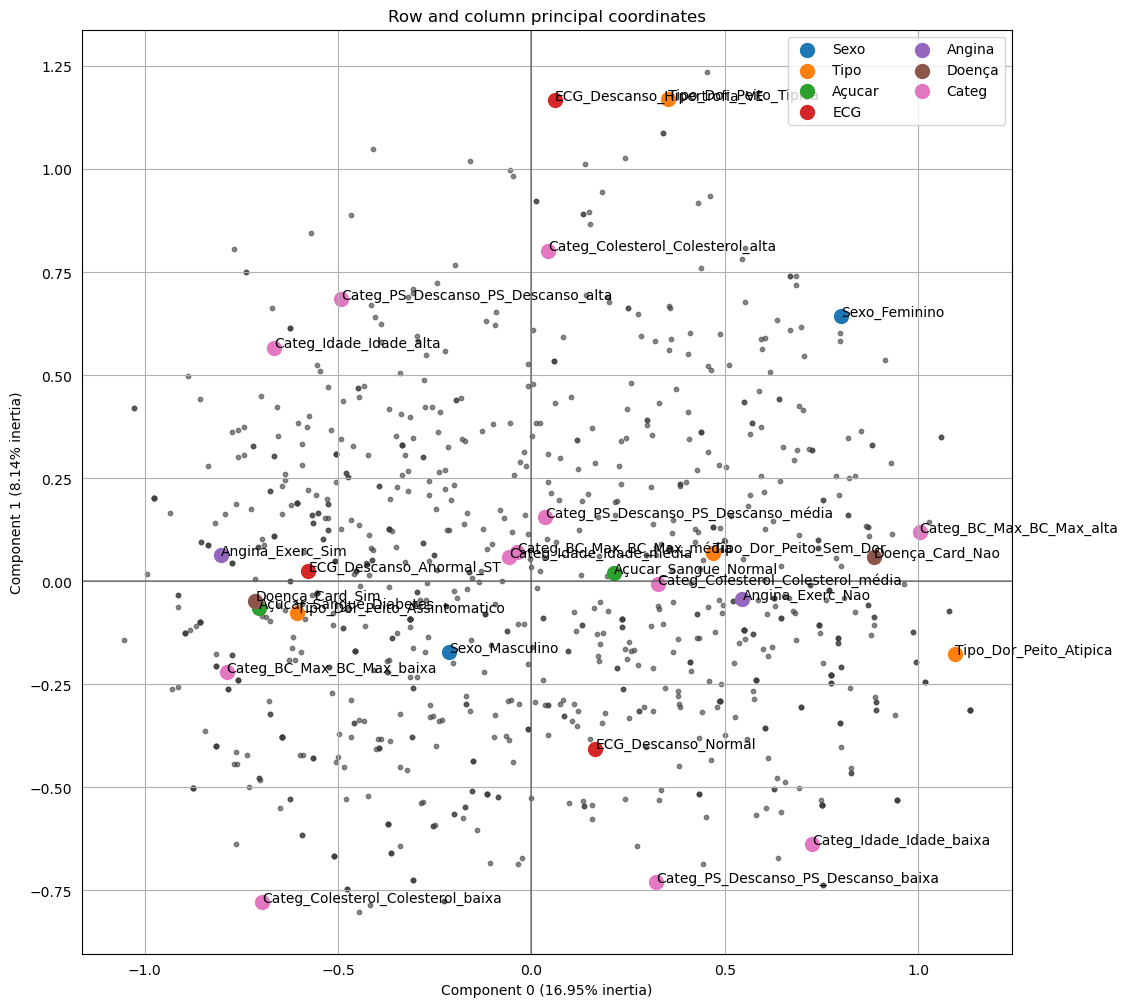

In [147]:
#%% Plotando o mapa perceptual

mp_mca = mca.plot_coordinates(
             X = df,
             figsize=(12,12),
             show_row_points = True,
             show_column_points = True,
             show_row_labels=False,
             column_points_size = 100,
             show_column_labels = True,
             legend_n_cols = 2)

# Exemplo 4: Gestão municipal(Anacor Simples / CA)

## 4.1. Base de dados

In [163]:
# pip install pyreadr

In [164]:
# Importando os dados
import pyreadr

result = pyreadr.read_r('datasets/gestao_municipal.RData') 
print(result.keys())

odict_keys(['gestao_municipal'])


In [165]:
df = result["gestao_municipal"]

df = df.rename(columns={'avaliaÃ§Ã£o': 'avaliação'})

In [166]:
#%% Visualizando os dados e cada uma das variáveis

df.head(5)


,avaliação,ano
0,Concordo Totalmente,20X1
1,Concordo Totalmente,20X1
2,Concordo Totalmente,20X1
3,Concordo Parcialmente,20X1
4,Concordo Totalmente,20X1


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   avaliação  9000 non-null   category
 1   ano        9000 non-null   category
dtypes: category(2)
memory usage: 18.0 KB


In [168]:
# Estatísticas descritivas
summary = df.describe(include = 'all')
summary


,avaliação,ano
count,9000,9000
unique,5,3
top,"Nem Concordo, Nem Discordo",20X1
freq,2970,3000


## 4.2. Anacor Simples

### - Análises Preliminares

In [169]:
# Tabelas de frequência das variáveis
tabela_contingencia = pd.crosstab(index=df['avaliação'], columns=df['ano'])
tabela_contingencia

ano,20X1,20X2,20X3
avaliação,,,
Concordo Parcialmente,1066,996,0
Concordo Totalmente,966,0,0
Discordo Parcialmente,1,998,1005
Discordo Totalmente,0,1,997
"Nem Concordo, Nem Discordo",967,1005,998


In [170]:
# Definição da quantidade de observações na tabela de contingência
n = tabela_contingencia.sum().sum()
n

9000

In [171]:
#%% Analisando a significância estatística da associação (teste qui²)
# Se o p valor é menor que 0.05 então se rejeita  hipótese nula, isto é, que as variáveis não 
# tem associação estatisticamente relevantes.

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf}") # graus de liberdade

estatística qui²: 5956.4356972909645
p-valor da estatística: 0.0
graus de liberdade: 8


### - Processo pelo Prince

In [173]:
#%% Elaborando a ANACOR

# Inicializando a instância da Anacor
ca = prince.CA()

In [174]:
#%% Fit do modelo

# Note que o input é a tabela de contingência criada antes

ca = ca.fit(tabela_contingencia)


In [175]:
#%% Obtendo as coordenadas em linha 
ca.row_coordinates(tabela_contingencia)

,0,1
Concordo Parcialmente,-0.634071,-0.315726
Concordo Totalmente,-1.222708,0.710623
Discordo Parcialmente,0.612588,-0.351081
Discordo Totalmente,1.225539,0.701462
"Nem Concordo, Nem Discordo",0.012753,-0.010750


In [176]:
#%% Obtendo as coordenadas em coluna

ca.column_coordinates(tabela_contingencia)

,0,1
20X1,-0.866950,0.283437
20X2,-0.002882,-0.564066
20X3,0.869832,0.280629


In [177]:
#%% Obtendo os eigenvalues

ca.eigenvalues_


[0.5027396130675039, 0.1590865755203808]

In [178]:
#%% Obtendo a inércia principal total

# É a soma dos eigenvalues (também é a divisão: estat. qui² / N)
# Quanto maior a inércia principal total, maior é a associação entre categorias

ca.total_inertia_

0.6618261885878851

In [179]:
#%% Inércia explicada por dimensão

# Indica o percentual da a inércia principal total explicado por cada dimensão

ca.explained_inertia_

[0.7596248406854094, 0.24037515931459005]

In [180]:
#%% Massas em linhas

ca.row_masses_


Concordo Parcialmente         0.229111
Concordo Totalmente           0.107333
Discordo Parcialmente         0.222667
Discordo Totalmente           0.110889
Nem Concordo, Nem Discordo    0.330000
dtype: float64

In [181]:
#%% Massas em colunas

ca.col_masses_

20X1    0.333333
20X2    0.333333
20X3    0.333333
dtype: float64

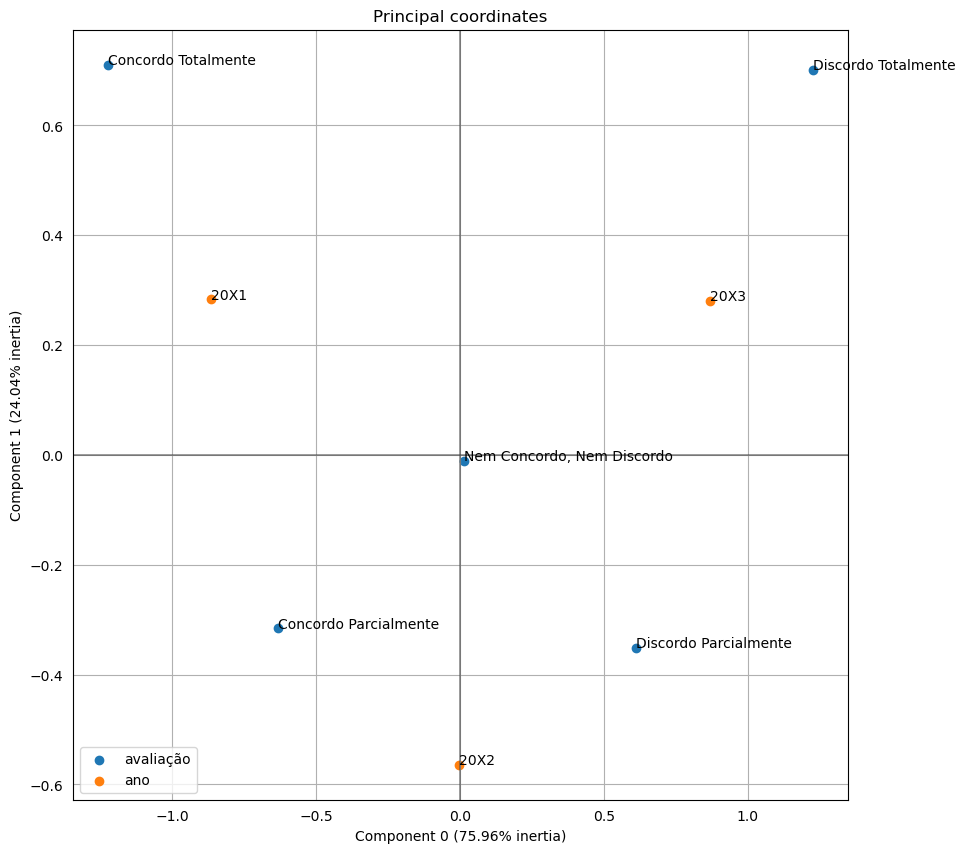

In [182]:
ax = ca.plot_coordinates(X=tabela_contingencia,
                         ax=None,
                         figsize=(10,10),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True)


# Exemplo 5: Adaptaçao de estudantes (Anacor Múlticpla / MCA)

## 5.1. Base de dados

In [196]:
df = pd.read_csv("datasets/estudantes_adapta.csv")

In [197]:
#%% Visualizando os dados e cada uma das variáveis

df.head(5)


,Education,Institution,Financial,Internet,Adaptivity
0,University,Non Government,Mid,Wifi,Moderate
1,University,Non Government,Mid,Mobile Data,Moderate
2,College,Government,Mid,Wifi,Moderate
3,School,Non Government,Mid,Mobile Data,Moderate
4,School,Non Government,Poor,Mobile Data,Low


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Education    1205 non-null   object
 1   Institution  1205 non-null   object
 2   Financial    1205 non-null   object
 3   Internet     1205 non-null   object
 4   Adaptivity   1205 non-null   object
dtypes: object(5)
memory usage: 47.2+ KB


In [199]:
# Estatísticas descritivas
summary = df.describe(include = 'all')
summary


,Education,Institution,Financial,Internet,Adaptivity
count,1205,1205,1205,1205,1205
unique,3,2,3,2,3
top,School,Non Government,Mid,Mobile Data,Moderate
freq,530,823,878,695,625


## 5.2. Anacor Múltipla

### - Análises Preliminares

In [200]:
# Tabelas de contingência (todas apresentam associação com alguma variável?)
tabela_contingencia = pd.crosstab(index=df['Adaptivity'], columns=df['Education'])
tabela_contingencia

Education,College,School,University
Adaptivity,,,
High,3,47,50
Low,120,182,178
Moderate,96,301,228


In [201]:
tabela_contingencia = pd.crosstab(index=df['Adaptivity'], columns=df['Institution'])
tabela_contingencia

Institution,Government,Non Government
Adaptivity,,
High,20,80
Low,234,246
Moderate,128,497


In [202]:
tabela_contingencia = pd.crosstab(index=df['Adaptivity'], columns=df['Financial'])
tabela_contingencia

Financial,Mid,Poor,Rich
Adaptivity,,,
High,36,22,42
Low,341,129,10
Moderate,501,91,33


In [203]:
tabela_contingencia = pd.crosstab(index=df['Adaptivity'], columns=df['Internet'])
tabela_contingencia

Internet,Mobile Data,Wifi
Adaptivity,,
High,36,64
Low,288,192
Moderate,371,254


### - Processo pelo Prince

In [204]:
#%% Elaborando a MCA 

## Utiliza o método da matriz de Burt

mca = prince.MCA()
mca = mca.fit(df)

In [205]:
#%% Obtendo as coordenadas nas duas dimensões do mapa

mca.column_coordinates(df)

,0,1
Education_College,-1.266116,0.559165
Education_School,0.476726,-0.675321
Education_University,0.053979,0.516366
Institution_Government,-0.846907,0.380226
Institution_Non Government,0.393097,-0.176484
Financial_Mid,-0.262792,0.125889
Financial_Poor,0.245959,-1.023834
Financial_Rich,2.014228,1.614552
Internet_Mobile Data,-0.057200,-0.631284
Internet_Wifi,0.077949,0.860279


In [206]:
#%% Obtendo as coordenadas de cada um das observações

mca.row_coordinates(df)




,0,1
0,0.164470,0.410168
1,0.116760,-0.127551
2,-0.739294,0.626296
3,0.265998,-0.557162
4,0.135029,-0.914878
...,...,...
1200,-0.612116,0.482365
1201,-0.301548,0.425598
1202,0.265998,-0.557162
1203,-0.612116,0.482365


In [207]:
#%% Obtendo os eigenvalues

mca.eigenvalues_



[0.3209691914742566, 0.30777456178624046]

In [208]:
#%% Inércia principal total

mca.total_inertia_



1.6

In [209]:
#%% Obtendo a variância

mca.explained_inertia_

[0.20060574467141037, 0.19235910111640028]

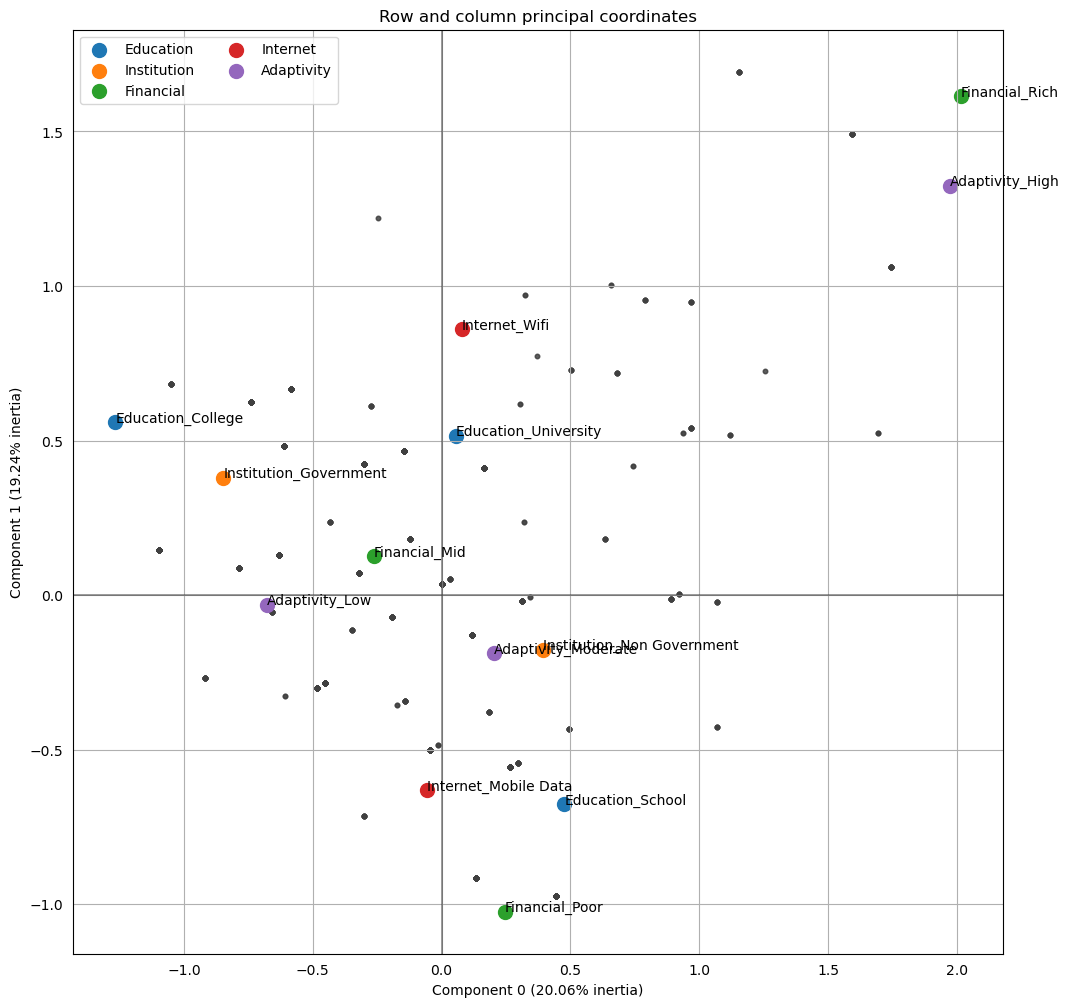

In [210]:
#%% Plotando o mapa perceptual

mp_mca = mca.plot_coordinates(
             X = df,
             figsize=(12,12),
             show_row_points = True,
             show_column_points = True,
             show_row_labels=False,
             column_points_size = 100,
             show_column_labels = True,
             legend_n_cols = 2)

# Exemplo 6: Classificação cursos (Anacor Simples / CA)

## 6.1. Base de dados

In [212]:
df1 = pd.read_excel('conceito_enade_2016.xlsx') 
df2 = pd.read_excel('conceito_enade_2021.xlsx') 

In [213]:
#%% Visualizando os dados e cada uma das variáveis

df1.head(5)


,Ano,Id_Curso,Categoria_Adm,Conceito_Enade
0,2016,1,Pública Federal,4
1,2016,2,Pública Federal,4
2,2016,3,Pública Federal,3
3,2016,4,Pública Federal,4
4,2016,5,Pública Federal,4


In [214]:
#%% Visualizando os dados e cada uma das variáveis

df2.head(5)


,Ano,Id_Curso,Categoria_Adm,Conceito_Enade
0,2021,1,Pública Federal,4
1,2021,2,Pública Federal,3
2,2021,3,Pública Federal,3
3,2021,4,Pública Federal,4
4,2021,5,Pública Federal,1


In [215]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Ano             4200 non-null   int64 
 1   Id_Curso        4200 non-null   int64 
 2   Categoria_Adm   4200 non-null   object
 3   Conceito_Enade  4200 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 131.4+ KB


In [216]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Ano             7497 non-null   int64 
 1   Id_Curso        7497 non-null   int64 
 2   Categoria_Adm   7497 non-null   object
 3   Conceito_Enade  7497 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 234.4+ KB


In [217]:
# Estatísticas descritivas
summary = df1.describe(include = 'all')
summary


,Ano,Id_Curso,Categoria_Adm,Conceito_Enade
count,4200.0,4200.000000,4200,4200.000000
unique,NaN,NaN,5,NaN
top,NaN,NaN,Privada sem fins lucrativos,NaN
freq,NaN,NaN,1750,NaN
mean,2016.0,2100.500000,NaN,3.057857
std,0.0,1212.579894,NaN,0.950669
min,2016.0,1.000000,NaN,1.000000
25%,2016.0,1050.750000,NaN,2.000000
50%,2016.0,2100.500000,NaN,3.000000
75%,2016.0,3150.250000,NaN,4.000000


In [218]:
# Estatísticas descritivas
summary = df2.describe(include = 'all')
summary


,Ano,Id_Curso,Categoria_Adm,Conceito_Enade
count,7497.0,7497.000000,7497,7497.000000
unique,NaN,NaN,5,NaN
top,NaN,NaN,Privada com fins lucrativos,NaN
freq,NaN,NaN,2252,NaN
mean,2021.0,3749.000000,NaN,2.958250
std,0.0,2164.341817,NaN,0.947525
min,2021.0,1.000000,NaN,1.000000
25%,2021.0,1875.000000,NaN,2.000000
50%,2021.0,3749.000000,NaN,3.000000
75%,2021.0,5623.000000,NaN,4.000000


## 6.2. Anacor Simples

### - Análises Preliminares

In [221]:
# Tabelas de frequência das variáveis
tabela_contingencia1 = pd.crosstab(index=df1['Categoria_Adm'], columns=df1['Conceito_Enade'])
tabela_contingencia1

Conceito_Enade,1,2,3,4,5
Categoria_Adm,,,,,
Privada com fins lucrativos,64,485,661,188,25
Privada sem fins lucrativos,74,409,771,420,76
Pública Estadual,11,33,71,123,36
Pública Federal,9,45,157,313,125
Pública Municipal,12,35,39,14,4


In [222]:
# Tabelas de frequência das variáveis
tabela_contingencia2 = pd.crosstab(index=df2['Categoria_Adm'], columns=df2['Conceito_Enade'])
tabela_contingencia2

Conceito_Enade,1,2,3,4,5
Categoria_Adm,,,,,
Privada com fins lucrativos,139,818,989,272,34
Privada sem fins lucrativos,54,501,724,387,86
Pública Estadual,50,353,469,278,59
Pública Federal,53,418,752,664,243
Pública Municipal,19,67,43,21,4


In [224]:
#%% Analisando a significância estatística da associação (teste qui²)
# Se o p valor é menor que 0.05 então se rejeita  hipótese nula, isto é, que as variáveis não 
# tem associação estatisticamente relevantes.

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia1)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf}") # graus de liberdade

estatística qui²: 778.6900483155465
p-valor da estatística: 2.2252295453838292e-155
graus de liberdade: 16


In [225]:
#%% Analisando a significância estatística da associação (teste qui²)
# Se o p valor é menor que 0.05 então se rejeita  hipótese nula, isto é, que as variáveis não 
# tem associação estatisticamente relevantes.

chi2, pvalor, dgf, freq_esp = chi2_contingency(tabela_contingencia2)

print(f"estatística qui²: {chi2}") # estatística qui²
print(f"p-valor da estatística: {pvalor}") # p-valor da estatística
print(f"graus de liberdade: {dgf}") # graus de liberdade

estatística qui²: 598.8297902833862
p-valor da estatística: 4.0502806750767916e-117
graus de liberdade: 16


### - Processo pelo Prince

#### 2016

In [226]:
#%% Elaborando a ANACOR

# Inicializando a instância da Anacor
ca = prince.CA()

In [227]:
#%% Fit do modelo

# Note que o input é a tabela de contingência criada antes

ca = ca.fit(tabela_contingencia1)


In [228]:
#%% Obtendo as coordenadas em linha 
ca.row_coordinates(tabela_contingencia1)

,0,1
Privada com fins lucrativos,-0.371938,0.029163
Privada sem fins lucrativos,-0.072318,-0.058256
Pública Estadual,0.569708,0.040295
Pública Federal,0.821212,0.023723
Pública Municipal,-0.319626,0.327040


In [229]:
#%% Obtendo as coordenadas em coluna

ca.column_coordinates(tabela_contingencia1)

,0,1
1,-0.270346,0.186467
2,-0.390451,0.061302
3,-0.202450,-0.055000
4,0.499565,-0.028392
5,0.957013,0.112982


In [230]:
#%% Obtendo os eigenvalues

ca.eigenvalues_


[0.17696242892420685, 0.004543521778812156]

In [231]:
#%% Obtendo a inércia principal total

# É a soma dos eigenvalues (também é a divisão: estat. qui² / N)
# Quanto maior a inércia principal total, maior é a associação entre categorias

ca.total_inertia_

0.18540239245608245

In [232]:
#%% Inércia explicada por dimensão

# Indica o percentual da a inércia principal total explicado por cada dimensão

ca.explained_inertia_

[0.9544775910382342, 0.024506273725072948]

In [233]:
#%% Massas em linhas

ca.row_masses_


Privada com fins lucrativos    0.338810
Privada sem fins lucrativos    0.416667
Pública Estadual               0.065238
Pública Federal                0.154524
Pública Municipal              0.024762
dtype: float64

In [234]:
#%% Massas em colunas

ca.col_masses_

1    0.040476
2    0.239762
3    0.404524
4    0.251905
5    0.063333
dtype: float64

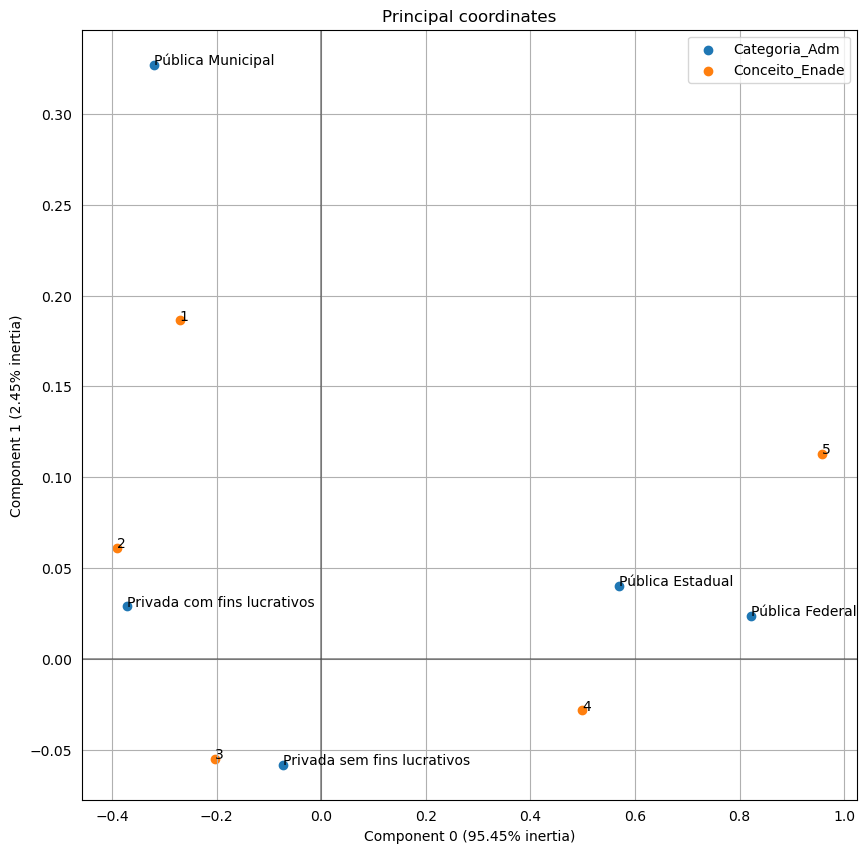

In [235]:
ax = ca.plot_coordinates(X=tabela_contingencia1,
                         ax=None,
                         figsize=(10,10),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True)


#### 2021

In [236]:
#%% Elaborando a ANACOR

# Inicializando a instância da Anacor
ca = prince.CA()

In [237]:
#%% Fit do modelo

# Note que o input é a tabela de contingência criada antes

ca = ca.fit(tabela_contingencia2)


In [238]:
#%% Obtendo as coordenadas em linha 
ca.row_coordinates(tabela_contingencia2)

,0,1
Privada com fins lucrativos,-0.325008,-0.002001
Privada sem fins lucrativos,-0.000468,-0.065418
Pública Estadual,-0.003054,-0.002425
Pública Federal,0.373504,0.028100
Pública Municipal,-0.383985,0.403869


In [239]:
#%% Obtendo as coordenadas em coluna

ca.column_coordinates(tabela_contingencia2)

,0,1
1,-0.382389,0.245455
2,-0.232472,0.024246
3,-0.072464,-0.059485
4,0.340207,0.005511
5,0.670903,0.090448


In [240]:
#%% Obtendo os eigenvalues

ca.eigenvalues_


[0.07439543633887546, 0.004577108927794154]

In [241]:
#%% Obtendo a inércia principal total

# É a soma dos eigenvalues (também é a divisão: estat. qui² / N)
# Quanto maior a inércia principal total, maior é a associação entre categorias

ca.total_inertia_

0.07987592240674754

In [242]:
#%% Inércia explicada por dimensão

# Indica o percentual da a inércia principal total explicado por cada dimensão

ca.explained_inertia_

[0.9313875082410428, 0.05730273641769552]

In [243]:
#%% Massas em linhas

ca.row_masses_


Privada com fins lucrativos    0.300387
Privada sem fins lucrativos    0.233693
Pública Estadual               0.161265
Pública Federal                0.284114
Pública Municipal              0.020542
dtype: float64

In [244]:
#%% Massas em colunas

ca.col_masses_

1    0.042017
2    0.287715
3    0.397092
4    0.216353
5    0.056823
dtype: float64

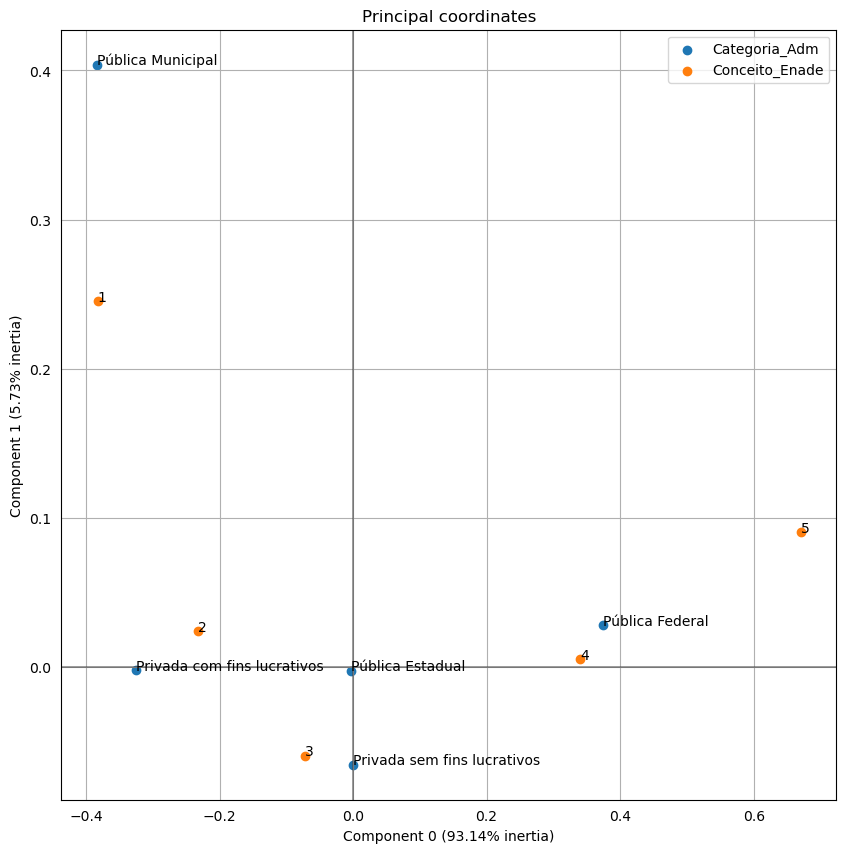

In [245]:
ax = ca.plot_coordinates(X=tabela_contingencia2,
                         ax=None,
                         figsize=(10,10),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True)
